In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###These files are from the [assign taxonomy notebook](./Assign_taxonomy.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [3]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10361 taxa and 466 samples ]
sample_data() Sample Data:       [ 466 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 10361 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10361 tips and 10360 internal nodes ]


### Get log2foldchange for CC

In [4]:
%%R
l2fc.threshold = 1
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C000",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [5]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C000"))

registerDoParallel(20)

df.l2fc.CC = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [6]:
%%R
df.l2fc.CC = df.l2fc.CC %>%
    group_by(sparsity_threshold, Treatment, Day) %>%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.CC

Source: local data frame [136,807 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C000 OTU.11642    -0.90172182 0.8921343 Bacteria
2                0.05  14    13C000 OTU.12643    -0.39624914 0.8189207 Bacteria
3                0.05  14    13C000 OTU.12562     0.77933903 0.5573120 Bacteria
4                0.05  14    13C000  OTU.4204    -0.20544785 1.0000000 Bacteria
5                0.05  14    13C000   OTU.467    -0.33034377 1.0000000 Bacteria
6                0.05  14    13C000   OTU.905     0.01698161 0.9819421 Bacteria
7                0.05  14    13C000  OTU.7253     0.02615064 0.9767846 Bacteria
8                0.05  14    13C000    OTU.67    -0.60130140 1.0000000 Bacteria
9                0.05  14    13C000 OTU.10580     0.35997190 0.7028140 Bacteria
10               0.05  14    13C000  OTU.4907     0.17895387 1.0000000 Bacteria
..                ... ...       ... 

### Get log2foldchange for 100

In [7]:
%%R
l2fc.threshold = 1
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C100",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [8]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C100"))

registerDoParallel(20)

df.l2fc.100 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [9]:
%%R
df.l2fc.100 = df.l2fc.100 %>% 
    group_by(sparsity_threshold, Treatment, Day) %>%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.100

Source: local data frame [123,320 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange          p
1                0.05  14    13C100 OTU.11642     1.86640621 0.26773008
2                0.05  14    13C100  OTU.4204    -0.12055084 0.99999919
3                0.05  14    13C100   OTU.467     0.55860664 0.82341110
4                0.05  14    13C100   OTU.905     0.20651232 0.81713282
5                0.05  14    13C100  OTU.7253     2.17512546 0.06674786
6                0.05  14    13C100    OTU.67     0.03413556 0.99759737
7                0.05  14    13C100 OTU.10580     3.21495409 0.05044622
8                0.05  14    13C100  OTU.4907     0.06688307 1.00000000
9                0.05  14    13C100  OTU.7898     0.32740807 0.99960079
10               0.05  14    13C100  OTU.8632     0.08524245 0.74477600
..                ... ...       ...       ...            ...        ...
Variables not shown: Rank1 (fctr), Rank2 (fctr), Ran

### Get log2foldchange for 700

In [10]:
%%R
l2fc.threshold = 1
density.min = 1.7125
density.max = 1.755
                           
get_Ps = function(physeq.obj, Treatment, Day, sparsity_threshold) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C700",as.character(Treatment)))&
                      (physeq.md$Day == Day)&
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc.threshold
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    r$p = p
    d = data.frame(r[, c("OTU","log2FoldChange", "p")])
    TT = data.frame(tax_table(p.thresh))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)
    d
}

In [11]:
%%R
m = expand.grid(sparsity_threshold = seq(0.05,0.95,0.05), 
                Day = c(14, 28, 45),
                Treatment = c("13C700"))

registerDoParallel(20)

df.l2fc.700 = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))

In [12]:
%%R
df.l2fc.700 = df.l2fc.700 %>% 
    group_by(sparsity_threshold, Treatment, Day) %>%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc.700

Source: local data frame [137,309 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C700  OTU.4204      0.2951127 0.9613699 Bacteria
2                0.05  14    13C700   OTU.467      1.1748995 0.3491355 Bacteria
3                0.05  14    13C700   OTU.905     -0.2726527 0.9655300 Bacteria
4                0.05  14    13C700  OTU.7253      1.7721812 0.1508338 Bacteria
5                0.05  14    13C700    OTU.67     -0.3273769 0.9999007 Bacteria
6                0.05  14    13C700 OTU.10580      1.0737168 0.4792051 Bacteria
7                0.05  14    13C700  OTU.4907      0.6242936 0.8106409 Bacteria
8                0.05  14    13C700  OTU.7898      0.4178486 0.9109400 Bacteria
9                0.05  14    13C700   OTU.125      0.3489531 0.9414329 Bacteria
10               0.05  14    13C700  OTU.3516      0.9217271 0.5209528 Bacteria
..                ... ...       ... 

In [13]:
%%R
df.l2fc.700 %>%
    group_by(Day, OTU) %>%
    summarize(N = n())

Source: local data frame [17,730 x 3]
Groups: Day

   Day       OTU  N
1   14     OTU.1 19
2   14    OTU.10 19
3   14   OTU.100 19
4   14  OTU.1000 16
5   14 OTU.10000  1
6   14  OTU.1001 16
7   14  OTU.1002 10
8   14  OTU.1003 16
9   14 OTU.10034  2
10  14 OTU.10036 18
.. ...       ... ..


### Combine SS and PS dataframes then determine sparsity threshold

In [14]:
%%R
combined_l2fc = rbind(df.l2fc.CC, df.l2fc.100, df.l2fc.700)
combined_l2fc

Source: local data frame [397,436 x 15]
Groups: sparsity_threshold, Treatment, Day

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.05  14    13C000 OTU.11642    -0.90172182 0.8921343 Bacteria
2                0.05  14    13C000 OTU.12643    -0.39624914 0.8189207 Bacteria
3                0.05  14    13C000 OTU.12562     0.77933903 0.5573120 Bacteria
4                0.05  14    13C000  OTU.4204    -0.20544785 1.0000000 Bacteria
5                0.05  14    13C000   OTU.467    -0.33034377 1.0000000 Bacteria
6                0.05  14    13C000   OTU.905     0.01698161 0.9819421 Bacteria
7                0.05  14    13C000  OTU.7253     0.02615064 0.9767846 Bacteria
8                0.05  14    13C000    OTU.67    -0.60130140 1.0000000 Bacteria
9                0.05  14    13C000 OTU.10580     0.35997190 0.7028140 Bacteria
10               0.05  14    13C000  OTU.4907     0.17895387 1.0000000 Bacteria
..                ... ...       ... 

In [15]:
%%R
d = combined_l2fc %>% 
    group_by(sparsity_threshold) %>%
    summarize(sum_pass_FDR = sum(padj < 0.10))
d

Source: local data frame [19 x 2]

   sparsity_threshold sum_pass_FDR
1                0.05         1241
2                0.10         1351
3                0.15         1410
4                0.20         1466
5                0.25         1478
6                0.30         1453
7                0.35         1436
8                0.40         1350
9                0.45         1269
10               0.50         1225
11               0.55         1176
12               0.60         1120
13               0.65         1035
14               0.70          978
15               0.75          914
16               0.80          835
17               0.85          749
18               0.90          590
19               0.95          314


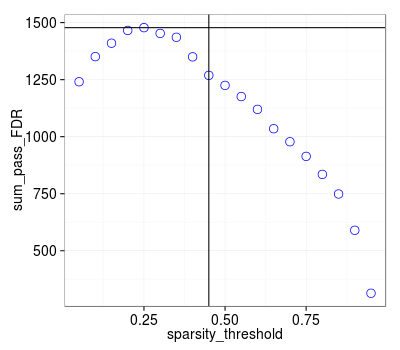

In [16]:
%%R -w 400 -h 350

p = ggplot(d, aes(x = sparsity_threshold, y = sum_pass_FDR))

p = p + geom_point(size = 4, shape = 21, color = "blue")

p = p + geom_vline(x = 0.45)

p = p + geom_hline(y = max(d$sum_pass_FDR))

p = p + theme_bw()
    
p = p + theme(axis.text = element_text(size = 14),
              axis.title = element_text(size = 14))

p

### Make dataframe that will be used for log2 fold change figures

In [17]:
%%R
sparsity.threshold = 0.25

df.l2fc = combined_l2fc %>% 
    filter(sparsity_threshold == sparsity.threshold) %>%
    group_by(Treatment) %>%
    mutate(padj = p.adjust(p, method = "BH"))

df.l2fc

Source: local data frame [28,471 x 15]
Groups: Treatment

   sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1                0.25  14    13C000  OTU.4204    -0.20553170 1.0000000 Bacteria
2                0.25  14    13C000   OTU.467    -0.33054855 1.0000000 Bacteria
3                0.25  14    13C000   OTU.905     0.01698885 0.9827594 Bacteria
4                0.25  14    13C000  OTU.7253     0.02799601 0.9772968 Bacteria
5                0.25  14    13C000    OTU.67    -0.60115954 1.0000000 Bacteria
6                0.25  14    13C000 OTU.10580     0.36193427 0.7248674 Bacteria
7                0.25  14    13C000  OTU.4907     0.17888830 1.0000000 Bacteria
8                0.25  14    13C000  OTU.7898     0.32255076 0.9997952 Bacteria
9                0.25  14    13C000   OTU.125    -0.15136470 1.0000000 Bacteria
10               0.25  14    13C000  OTU.3516    -0.19219773 0.9230245 Bacteria
..                ... ...       ...       ...            ...  

In [18]:
%%R
df.l2fc %>%
    group_by(OTU, Treatment, Day) %>%
    summarize(N = n()) %>%
    group_by() %>%
    select(N) %>% table

.
    1 
28471 


In [19]:
%%R

write.table(df.l2fc, 
            file = "/var/seq_data/priming_exp/data/l2fc_table.csv",
            row.names = FALSE,
            sep = ",")

In [20]:
!head /var/seq_data/priming_exp/data/l2fc_table.csv | cut -c1-100

"sparsity_threshold","Day","Treatment","OTU","log2FoldChange","p","Rank1","Rank2","Rank3","Rank4","R
0.25,14,"13C000","OTU.4204",-0.205531701239712,0.999999999119881,"Bacteria","Acidobacteria","DA023",
0.25,14,"13C000","OTU.467",-0.330548553300832,0.999999982731364,"Bacteria","Acidobacteria","DA023","
0.25,14,"13C000","OTU.905",0.0169888452768943,0.98275935620644,"Bacteria","Acidobacteria","DA023","u
0.25,14,"13C000","OTU.7253",0.0279960060272561,0.977296834489245,"Bacteria","Acidobacteria","DA023",
0.25,14,"13C000","OTU.67",-0.601159535735615,0.999999999999011,"Bacteria","Acidobacteria","DA023","u
0.25,14,"13C000","OTU.10580",0.361934266673033,0.724867415301275,"Bacteria","Acidobacteria","DA023",
0.25,14,"13C000","OTU.4907",0.178888304633832,0.999999999998607,"Bacteria","Acidobacteria","DA023","
0.25,14,"13C000","OTU.7898",0.322550757768054,0.999795162052008,"Bacteria","Acidobacteria","DA023","
0.25,14,"13C000","OTU.125",-0.151364699322406,0.999999999999992,"Bacteria","Acidobacteria",